<a href="https://colab.research.google.com/github/arshambt/MachineLearning2023/blob/main/Bachelor's_Final_Project/GAN_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN1

In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = define_discriminator()

In [ ]:
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

generator = define_generator(100)



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

gan_model = define_gan(generator, discriminator)

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

In [ ]:
model = load_model('model_%04d.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

OSError: No file or directory found at model_%04d.h5

# GAN 2

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 114384907.90it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 17540644.92it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32570047.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7901505.09it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_set)

60000

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)


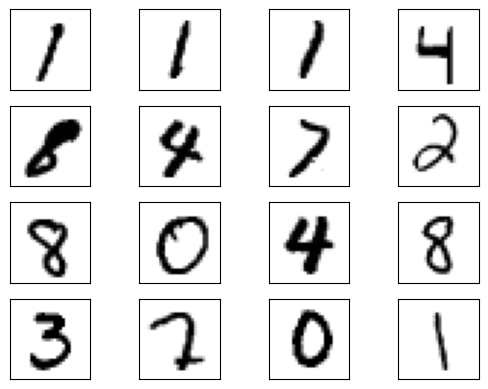

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(784, 1024),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(1024, 512),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(512, 256),

            nn.ReLU(),

            nn.Dropout(0.3),

            nn.Linear(256, 1),

            nn.Sigmoid(),

        )


    def forward(self, x):

        x = x.view(x.size(0), 784)

        output = self.model(x)

        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(100, 256),

            nn.ReLU(),

            nn.Linear(256, 512),

            nn.ReLU(),

            nn.Linear(512, 1024),

            nn.ReLU(),

            nn.Linear(1024, 784),

            nn.Tanh(),

        )


    def forward(self, x):

        output = self.model(x)

        output = output.view(x.size(0), 1, 28, 28)

        return output


generator = Generator().to(device=device)

In [ ]:
class Generator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            #nn.Linear(100, 256),

            #nn.ReLU(),

            #nn.Linear(256, 512),

            #nn.ReLU(),

            #nn.Linear(512, 1024),

            #nn.ReLU(),

            #nn.Linear(1024, 784),

            nn.ConvTranspose2d(1, 64, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 24, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=1, padding=0),
            nn.Tanh()

        )


    def forward(self, x):
      x = x.view(x.size(0), 1, 10, 10)
      output = self.model(x)
      output = output.view(x.size(0), 1, 28, 28)
      return output


generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
import numpy as np

np.ones((1,5))

array([[1., 1., 1., 1., 1.]])

In [ ]:
for epoch in range(num_epochs):

    for n, (real_samples, mnist_labels) in enumerate(train_loader):

        # Data for training the discriminator

        real_samples = real_samples.to(device=device)

        real_samples_labels = torch.ones((batch_size, 1)).to(

            device=device

        )

        latent_space_samples = torch.randn((batch_size, 100)).to(

            device=device

        )

        generated_samples = generator(latent_space_samples)

        generated_samples_labels = torch.zeros((batch_size, 1)).to(

            device=device

        )

        all_samples = torch.cat((real_samples, generated_samples))

        all_samples_labels = torch.cat(

            (real_samples_labels, generated_samples_labels)

        )


        # Training the discriminator

        discriminator.zero_grad()

        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(

            output_discriminator, all_samples_labels

        )

        loss_discriminator.backward()

        optimizer_discriminator.step()


        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 100)).to(

            device=device

        )


        # Training the generator

        generator.zero_grad()

        generated_samples = generator(latent_space_samples)

        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(

            output_discriminator_generated, real_samples_labels

        )

        loss_generator.backward()

        optimizer_generator.step()


        # Show loss

        if n == batch_size - 1:

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692472457885742
Epoch: 0 Loss G.: 0.47791537642478943


KeyboardInterrupt: 

In [ ]:
print(real_samples.shape)

torch.Size([32, 1, 28, 28])


In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

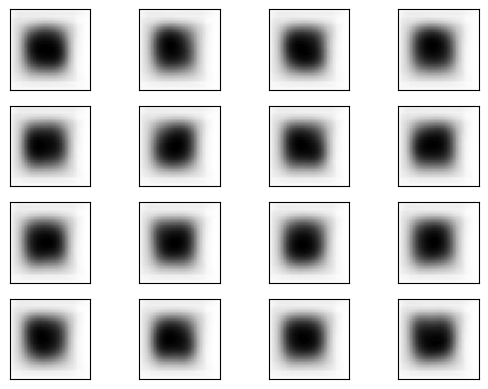

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


# GAN 2 (Tensorflow)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import to_categorical

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = tf.expand_dims(train_images, axis=-1)

train_images.shape

TensorShape([60000, 28, 28, 1])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.batch(32)

for element in dataset:
  i = 0

print(element[0].shape)

(32, 28, 28, 1)


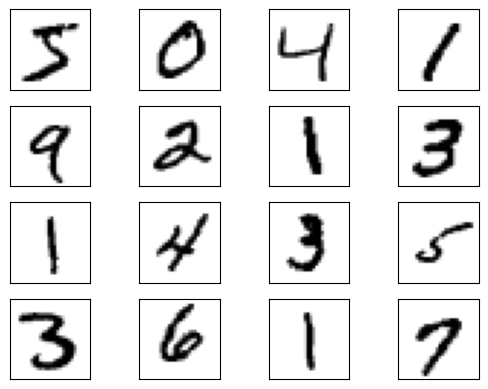

In [ ]:
#real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i], cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
"""class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = Sequential([
        Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)),
        MaxPool2D(pool_size=(1,1)),

        Flatten(),

        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid')
  ])

    def call(self, inputs):
        return self.model(inputs)

In [ ]:
"""class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator,self).__init__()
    self.model = Sequential([
        Conv2DTranspose(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(10,10,1)),
        Conv2DTranspose(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'),
        Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='valid', activation='relu'),
        Conv2DTranspose(16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'),
        Conv2DTranspose(12, kernel_size=(3,3), strides=(2,2), padding='valid', activation='relu'),
        Conv2DTranspose(1, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')
    ])

    #def call(self, inputs, training=None, mask=None):
        # Define the forward pass of the model
        #return self.model(inputs, training=training, mask=mask)
    def call(self, input):
      input = input.reshape(input[0], 1, 10, 10)
      output = self.model(input)
      output = output.view(input, 1, 28, 28)
      return output

In [ ]:
class Discriminator:
  def __init__(self):

    self.model = Sequential()
    self.model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    self.model.add(MaxPool2D(pool_size=(1,1)))

    self.model.add(Flatten())

    self.model.add(Dense(100, activation='relu'))
    self.model.add(Dense(1, activation='sigmoid'))

  def fit(self, x_train, y_train):
    self.model.compile(loss='BinaryCrossentropy', metrics=['accuracy'], optimizer='adam')
    self.model.fit(x_train, y_train)

  def prediction(self, input):
    pred = self.model.predict(input)
    return pred



In [ ]:
"""def Discriminator(input, x_train, y_train):
  d_model = Sequential()
  d_model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
  d_model.add(MaxPool2D(pool_size=(1,1)))

  d_model.add(Flatten())

  d_model.add(Dense(100, activation='relu'))
  d_model.add(Dense(1, activation='sigmoid'))

  d_model.compile(loss='BinaryCrossentropy', metrics=['accuracy'], optimizer='adam')
  d_model.fit(x_train, y_train)

  if input != None:
    return d_model.predict(input)

In [ ]:
class Generator(keras.Model):
  def __init__(self):
    self.model = Sequential()
    self.model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu', input_shape=(10,10,1)))
    self.model.add(Conv2DTranspose(32, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
    self.model.add(Conv2DTranspose(32, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
    self.model.add(Conv2DTranspose(16, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
    self.model.add(Conv2DTranspose(12, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
    self.model.add(Conv2DTranspose(1, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))

  def train(self):
    with tf.GradientTape() as tape:
      g_loss = loss(y_true, y_pred)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.model.compile(loss = self.custom_loss, metrics=['accuracy'], optimizer='adam')
    self.model.fit(x_train, y_train)

  def prediction(self, input):
    pred = self.model.predict(input)
    return pred

NameError: name 'keras' is not defined

In [ ]:
"""def Generator(input, x_train, y_train):
  g_model = Sequential()
  g_model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu', input_shape=(10,10,1)))
  g_model.add(Conv2DTranspose(32, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
  g_model.add(Conv2DTranspose(32, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
  g_model.add(Conv2DTranspose(16, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
  g_model.add(Conv2DTranspose(12, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))
  g_model.add(Conv2DTranspose(1, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'))

  g_model.compile(loss='BinaryCrossentropy', metrics=['accuracy'], optimizer='adam')
  g_model.fit(x_train, y_train)

  if input != None:
    return g_model.predict(input)

In [ ]:
for n, (real_samples, mnist_labels) in enumerate(dataset):
  i=0

print(mnist_labels[0])

tf.Tensor(5, shape=(), dtype=uint8)


In [ ]:
epochs = 50
batch_size = 32
i=0
generator = Generator()
discriminator = Discriminator()

for epoch in range(epochs):

    for n, (real_samples, mnist_labels) in enumerate(dataset):
        print(i)
        i = i+1
        # Data for training the discriminator

        #real_samples = real_samples

        real_samples_labels = tf.ones((batch_size, 1))

        latent_space_samples = tf.random.normal((batch_size, 100))
        latent_space_samples = tf.reshape(latent_space_samples, (32,10,10,1))

        generated_samples = generator.prediction(latent_space_samples)

        generated_samples_labels = tf.zeros((batch_size, 1))

        #print(generated_samples)

        all_samples = tf.concat((real_samples, generated_samples), axis=0)

        all_samples_labels = tf.concat((real_samples_labels, generated_samples_labels), axis=0)


        # Training the discriminator

        discriminator.fit(all_samples, all_samples_labels)


        # Data for training the generator

        latent_space_samples = tf.random.normal((batch_size, 100))
        latent_space_samples = tf.reshape(latent_space_samples, (32,10,10,1))

        # Training the generator

        generated_samples = generator.prediction(latent_space_samples)

        output_discriminator_generated = discriminator.prediction(generated_samples)

        generator.loss(real_samples_labels, output_discriminator_generated)
        generator.fit(latent_space_samples, real_samples_labels)


        # Show loss

        #if n == batch_size - 1:

            #print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            #print(f"Epoch: {epoch} Loss G.: {loss_generator}")

0
1/1 [==============================] - 0s 145ms/step


InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [32,28,28,1] vs. shape[1] = [32,22,22,1] [Op:ConcatV2] name: concat

In [ ]:
print(real_samples.shape)
print(generated_samples.shape)

(32, 28, 28, 1)
(32, 28, 28, 1)
